# **TAREA: Entrenamiento de una red CNN desde cero**

## **1. Instalación**

In [ ]:
!pip install pytorch-lightning
!pip install torchview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 18.4 MB/s eta 0:00:00


## **2. Importar Librerías**

In [ ]:
import zipfile # Manipulación de archivos comprimidos
import os
import shutil
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader # Importación de DataLoader para cargar datos en lotes durante el entrenamiento
from torch.utils.data import Dataset # Importación de la clase base Dataset para construir datasets personalizados en PyTorch
from torchmetrics.classification import Accuracy
from torchview import draw_graph
from torch import optim
from pytorch_lightning import callbacks as pl_callbacks
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from glob import glob
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split


## **3. Configurar DataSet**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#path_zip = '/content/drive/MyDrive/UTEC/C2023-II/CS8127_MachineLearning/ProyectoML4/V2/Mariposas.zip'
path_zip = '/content/drive/MyDrive/MagComputerScience/C2023-II/MachineLearning/ProyectoML4/Mariposas.zip'
#local_zip = '/tmp/Vegetables.zip'
zip_ref = zipfile.ZipFile(path_zip, 'r')
zip_ref.extractall('dataMariposas/')
zip_ref.close()

In [ ]:
# Directorio principal de tu conjunto de datos
base_dir = 'dataMariposas/'

# Obtener la lista de todos los archivos en el directorio de imágenes
image_dir = os.path.join(base_dir, 'images')
all_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Función para obtener el número de especie de un nombre de archivo
def get_species(file_name):
    return int(file_name[:3])  # Suponiendo que los primeros tres caracteres representan el número de especie

# Dividir el conjunto de datos en entrenamiento, prueba y validación
train_files, test_val_files = train_test_split(all_files, test_size=0.3, random_state=42)
test_files, validation_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

# Función para organizar los archivos en carpetas según la especie y el conjunto
def organize_files(files, destination_dir):
    for file in files:
        species = get_species(file)
        species_dir = os.path.join(destination_dir, f"{species:03d}")
        os.makedirs(species_dir, exist_ok=True)
        shutil.copy(os.path.join(image_dir, file), os.path.join(species_dir, file))

# Directorios de salida para los conjuntos de entrenamiento, prueba y validación
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

# Organizar los archivos en las carpetas correspondientes
organize_files(train_files, train_dir)
organize_files(test_files, test_dir)
organize_files(validation_files, validation_dir)

print("Dataset dividido y organizado correctamente.")


Dataset dividido y organizado correctamente.


In [ ]:
#title **1. Dividir los datos de forma interna**
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, img_size=224, batch_size=200):
        super().__init__()

        # Directorio que contiene los datos
        self.data_dir = data_dir
        # Tamaño de las imágenes
        self.img_size = img_size

        # Transformación para las imágenes de prueba (no se aplica aumento de datos)
        self.test_transform = transforms.Compose([
            transforms.Resize(size=(self.img_size, self.img_size)),
            transforms.ToTensor(),  # 0-1
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Transformación para las imágenes de entrenamiento (incluye aumento de datos)
        self.train_transform = transforms.Compose([
            transforms.Resize(size=(self.img_size, self.img_size)),
            transforms.RandomRotation(degrees=10),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Tamaño del lote y número de trabajadores para la carga de datos
        self.batch_size = batch_size
        self.num_workers = multiprocessing.cpu_count()

    def setup(self, stage=None):
        # Rutas a los conjuntos de entrenamiento y prueba
        path_train = os.path.join(self.data_dir, 'train')
        path_test = os.path.join(self.data_dir, 'validation')

        # Crear conjuntos de datos PyTorch ImageFolder
        mydataset_train = datasets.ImageFolder(root=path_train)
        mydataset_test = datasets.ImageFolder(root=path_test)

        # Almacenar la ruta al conjunto de prueba
        self.path_test = path_test

        # Obtener las categorías del conjunto de prueba
        self.categories = mydataset_test.class_to_idx

        # Crear conjuntos de datos personalizados con las transformaciones especificadas
        traindataset = custom_dataset(mydataset_train, self.train_transform)  # entrenamiento
        self.testdataset = custom_dataset(mydataset_test, self.test_transform)  # prueba

        # Dividir los datos en conjuntos de entrenamiento y validación
        train_size = 0.9
        num_train = len(mydataset_train)
        indices = list(range(num_train))
        split = int(np.floor(train_size * num_train))
        np.random.shuffle(indices)
        train_idx, valid_idx = indices[:split], indices[split:]
        self.traindata = torch.utils.data.Subset(traindataset, indices=train_idx)
        self.validdata = torch.utils.data.Subset(traindataset, indices=valid_idx)

    # Funciones para crear los dataloaders
    def train_dataloader(self):
        train_loader = DataLoader(
            self.traindata,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle = True,
            drop_last=True)
        return train_loader
    def val_dataloader(self):
        valid_loader = DataLoader(
            self.validdata,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            drop_last=True)
        return valid_loader
    def test_dataloader(self):
        test_loader = DataLoader(
            self.testdataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            drop_last=True)
        return test_loader

## **4. Mostrar Imágenes**

In [ ]:
class custom_dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]

        # Aqui, ustedes pueden modificar o
        # alterar la imagen según su propuesta de investigación
        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)

In [ ]:
def show_samples_dataset(base_dir, type_data, c=10, r = 5):
  print("|"*30, type_data, "|"*30)
  fig       = plt.figure(figsize=(20,10))
  path_data = os.path.join(base_dir, type_data)
  data_set  = custom_dataset(datasets.ImageFolder(root = path_data))

  for i in range(1,c*r + 1):
    idx = torch.randint(data_set.__len__(), size=(1,)).item()
    img, label = data_set.__getitem__(idx)
    img = img.resize((100, 100))
    fig.add_subplot(r,c,i)
    plt.title(f"label: {label+1}")
    plt.axis("off")
    plt.imshow(img)
  plt.show()

|||||||||||||||||||||||||||||| train ||||||||||||||||||||||||||||||


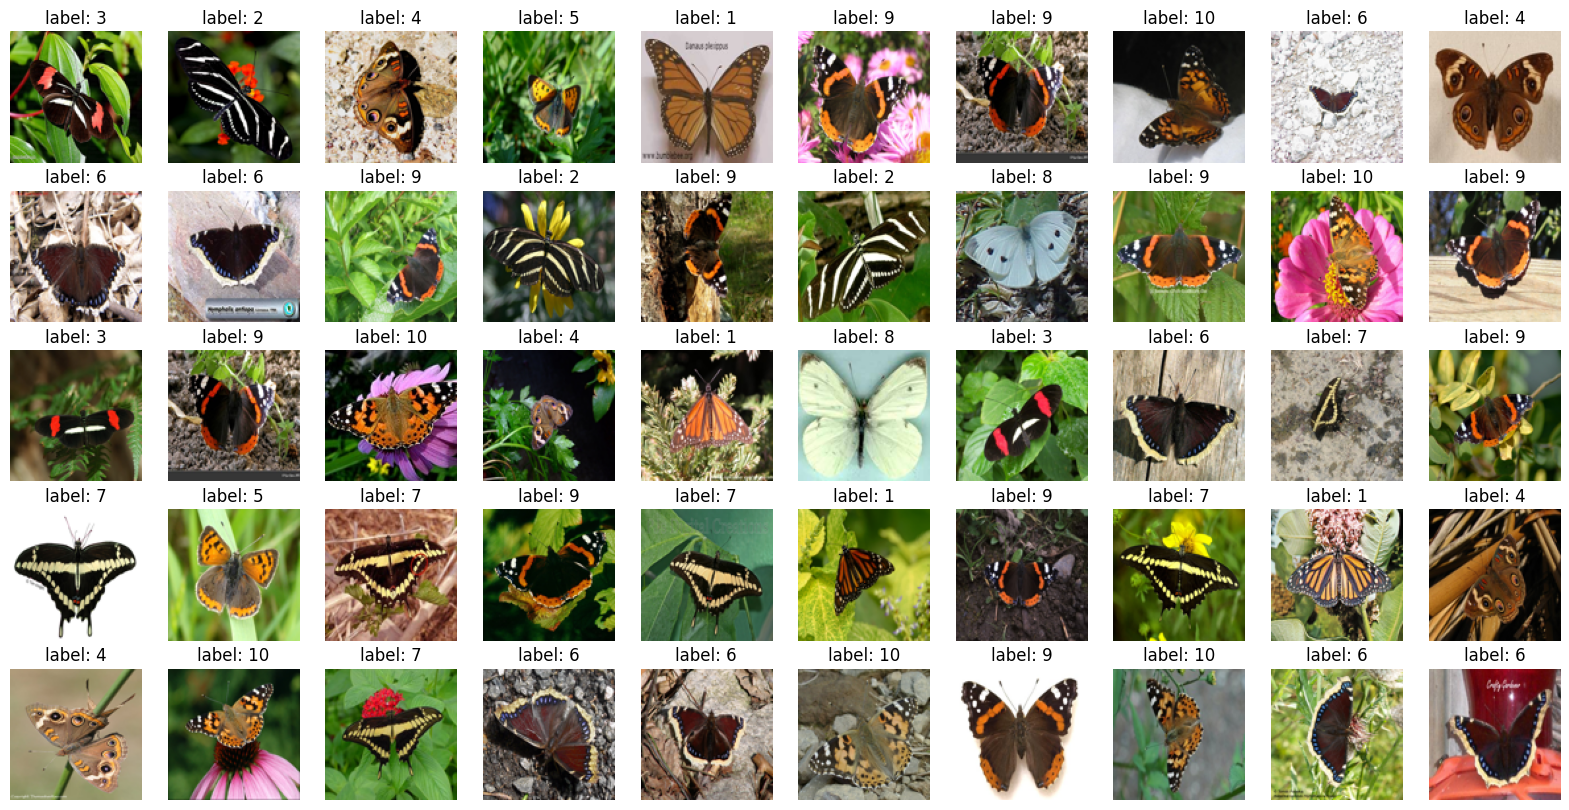

|||||||||||||||||||||||||||||| validation ||||||||||||||||||||||||||||||


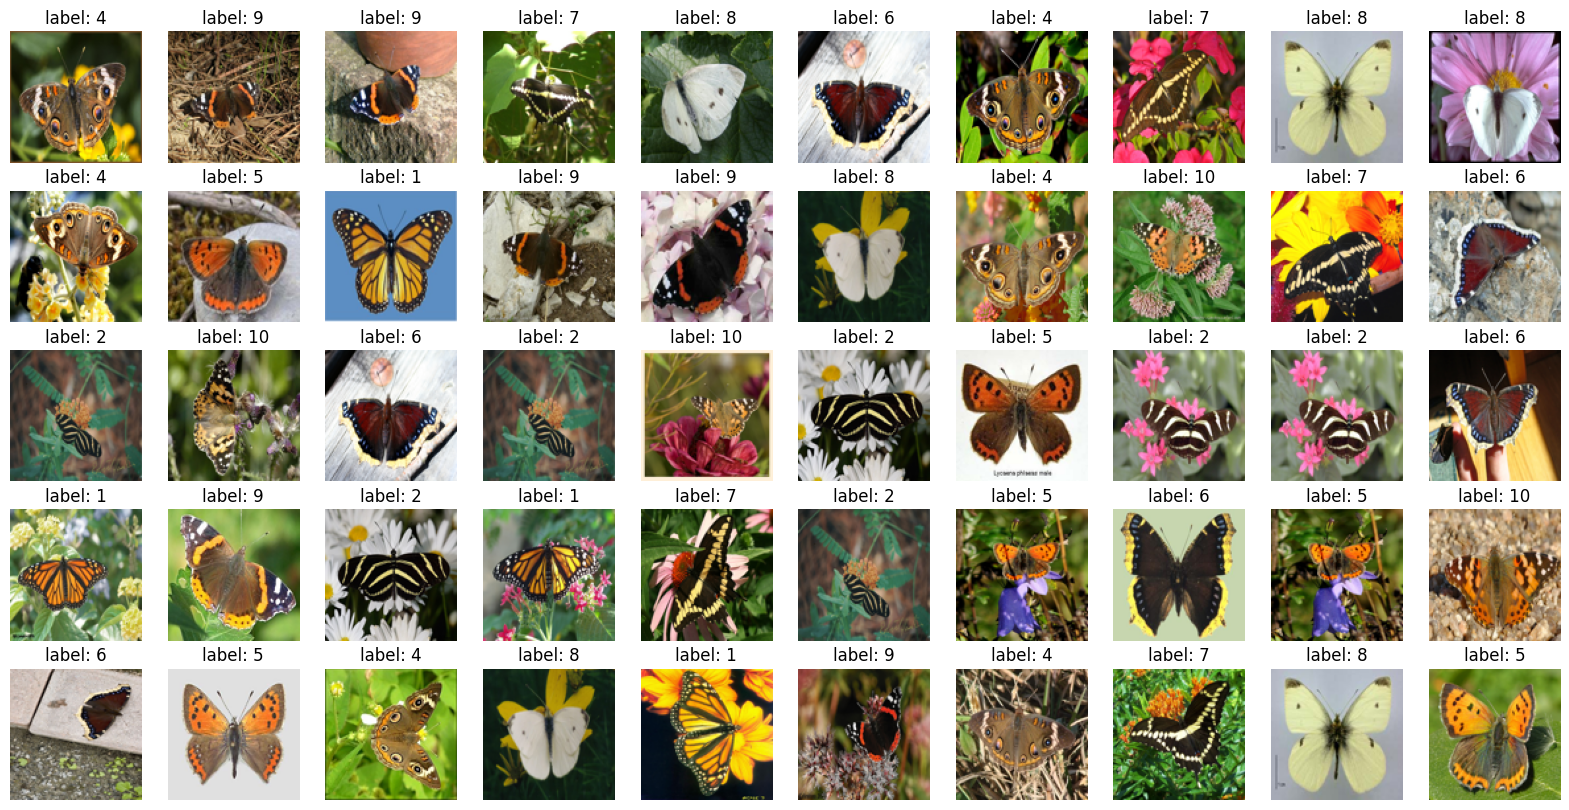

In [ ]:
base_dir = "/content/dataMariposas/"
#show_samples_dataset(base_dir,'images')
show_samples_dataset(base_dir, 'train')
show_samples_dataset(base_dir, 'validation')

In [ ]:
def show_data_size(DATA_PATH, type_data, extensions=['jpg', 'png']):
    DATA_PATH = os.path.join(DATA_PATH, type_data)
    list_dire_clases = [f.path for f in os.scandir(DATA_PATH) if f.is_dir()]
    list_name_clases = sorted([os.path.basename(x) for x in list_dire_clases])  # Ordenar los nombres de las clases
    cantidades = []
    print(f"Datos de {type_data}: ")
    for class_path, class_name in zip(list_dire_clases, list_name_clases):
        # Buscar archivos con las extensiones especificadas
        files_annot = []
        for ext in extensions:
            files_annot.extend(glob(os.path.join(class_path, f"*.{ext}")))
        files_names = [os.path.basename(x) for x in files_annot]
        print(f"Clase {class_name} tiene {len(files_annot)} registros")
        tama = len(files_annot)
        cantidades.append(len(files_annot))

    # Configuraciones de la gráfica
    cmap = get_cmap('viridis')  # Puedes cambiar 'viridis' a otro mapa de colores
    colors = [cmap(i/len(list_name_clases)) for i in range(len(list_name_clases))]  # Asignar colores según el cmap
    bars = plt.bar(list_name_clases, cantidades, color=colors, edgecolor='black')  # Color de las barras
    plt.title(f"Distribución de Clases en {type_data}")  # Título de la gráfica
    plt.xlabel("Clases")  # Etiqueta del eje x
    plt.ylabel("Cantidad de Registros")  # Etiqueta del eje y
    plt.xticks(rotation=45, ha='right')  # Rotar y ajustar la alineación de las etiquetas del eje x

    # Leyenda personalizada para los colores
    legend_labels = [f'Clase {class_name}' for class_name in list_name_clases]
    legend_elements = [Line2D([0], [0], color=color, label=label, marker='o') for color, label in zip(colors, legend_labels)]
    plt.legend(handles=legend_elements, title='Clases', loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.show()

    return cantidades

Datos de train: 
Clase 001 tiene 67 registros
Clase 002 tiene 78 registros
Clase 003 tiene 59 registros
Clase 004 tiene 47 registros
Clase 005 tiene 33 registros
Clase 006 tiene 59 registros
Clase 007 tiene 64 registros
Clase 008 tiene 58 registros
Clase 009 tiene 58 registros
Clase 010 tiene 59 registros


<ipython-input-10-73f2c279f33b>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')  # Puedes cambiar 'viridis' a otro mapa de colores


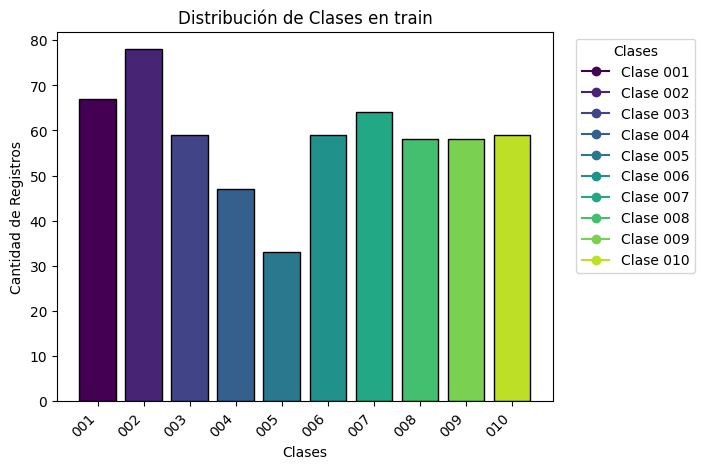

In [ ]:
cant_samples = show_data_size("/content/dataMariposas", "train")

In [ ]:
dm = DataModule(data_dir = "/content/dataMariposas", img_size = 224, batch_size=10)
dm.setup()
class_names = dm.categories
loader = dm.train_dataloader()
for i, (x, y) in enumerate(loader):
  print(f"step {i}: {x.shape}")

step 0: torch.Size([10, 3, 224, 224])
step 1: torch.Size([10, 3, 224, 224])
step 2: torch.Size([10, 3, 224, 224])
step 3: torch.Size([10, 3, 224, 224])
step 4: torch.Size([10, 3, 224, 224])
step 5: torch.Size([10, 3, 224, 224])
step 6: torch.Size([10, 3, 224, 224])
step 7: torch.Size([10, 3, 224, 224])
step 8: torch.Size([10, 3, 224, 224])
step 9: torch.Size([10, 3, 224, 224])
step 10: torch.Size([10, 3, 224, 224])
step 11: torch.Size([10, 3, 224, 224])
step 12: torch.Size([10, 3, 224, 224])
step 13: torch.Size([10, 3, 224, 224])
step 14: torch.Size([10, 3, 224, 224])
step 15: torch.Size([10, 3, 224, 224])
step 16: torch.Size([10, 3, 224, 224])
step 17: torch.Size([10, 3, 224, 224])
step 18: torch.Size([10, 3, 224, 224])
step 19: torch.Size([10, 3, 224, 224])
step 20: torch.Size([10, 3, 224, 224])
step 21: torch.Size([10, 3, 224, 224])
step 22: torch.Size([10, 3, 224, 224])
step 23: torch.Size([10, 3, 224, 224])
step 24: torch.Size([10, 3, 224, 224])
step 25: torch.Size([10, 3, 224, 22

## **5. Arquitecturas**

### **_5.0. Arquitectura Red Neuronal Simple**

In [ ]:
class SimpleNN(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes, lr=1e-3, dropout_rate=0.5):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lr = lr
        self.dropout_rate = dropout_rate
        self.results = {"val_loss": [], "val_acc": [], "train_loss": [], "train_acc": []}

        # Capas totalmente conectadas
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.num_classes)

        # Dropout para prevenir sobreajuste
        self.dropout = nn.Dropout(p=self.dropout_rate)

        # Función de pérdida y métricas
        self.loss = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplanar la entrada si es necesario
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        output = F.softmax(self.fc2(x), dim=1)

        return output

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        self.train_acc(preds, targets)

        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        preds = torch.argmax(outputs, dim=1)
        self.valid_acc(preds, targets)
        self.log('val_loss', loss)
        self.log('val_acc', self.valid_acc)
        return loss

    def test_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        preds = torch.argmax(outputs, dim=1)
        self.test_acc(preds, targets)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


### **_5.1. Arquitectura CNN_1**

In [ ]:
class CustomCNN(pl.LightningModule):
    def __init__(self, num_classes = 15, lr = 1e-3):
        super().__init__()

        self.num_classes = num_classes
        self.lr = lr
        self.results = {"val_loss":[], "val_acc":[], "train_loss":[], "train_acc":[]}

        self.conv1 = nn.Sequential(
              nn.Conv2d(
                in_channels=3,     # dimension de la imagen RGB = 3, escala de grises = 1
                out_channels=16,   # numero de filtros
                kernel_size=3,     # tamaño del filtro
                stride=1,          # valor de desplazamiento
                padding=1          # valor de relleno a los extremos
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
          )

        self.conv2 = nn.Sequential(
          nn.Conv2d(16, 32, 3, 1, 1),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
          nn.Conv2d(32, 64, 3, 1, 1),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )

        self.adapt = nn.AdaptiveMaxPool2d((8,8))
        self.fc = nn.Linear(64 * 8 * 8, self.num_classes)

        # 3 Loss function
        self.loss = nn.CrossEntropyLoss()

        # 4 Metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc  = Accuracy(task="multiclass", num_classes=self.num_classes)

        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.adapt(x)
      x = x.view(x.size(0), -1) # se vuelve un vector 1d
      output = self.fc(x)

      return output

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        self.train_acc(preds, targets)

        loss = self.loss(outputs, targets)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        self.valid_acc(preds, targets)

        loss = self.loss(outputs, targets)
        self.val_losses.append(loss.item())

        # Registrar la métrica 'val_loss'
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss


    def on_epoch_end(self):
        # Obtener y almacenar las pérdidas de entrenamiento y validación al final de cada época
        train_loss = self.trainer.callback_metrics.get("train_loss_epoch")
        val_loss = self.trainer.callback_metrics.get("val_loss_epoch")

        if train_loss is not None:
            self.train_losses.append(train_loss)

        if val_loss is not None:
            self.val_losses.append(val_loss)

        print(f"Epoch {self.current_epoch}: Train Loss={train_loss}, Val Loss={val_loss}")


    def get_loss_values(self):
        # Devolver las pérdidas recopiladas de entrenamiento y validación
        return self.train_losses, self.val_losses


    def on_training_epoch_end(self):
        acc =self.train_acc.compute()
        self.log('avg_train_acc',acc)
        print(f"avg_train_acc: {acc}, ", end=" ")

    def on_validation_epoch_end(self):
        avg_val_acc = self.valid_acc.compute()
        self.log('avg_val_acc',avg_val_acc)
        print(f"avg_val_acc: {avg_val_acc}")

    def test_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        #preds = nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        #print(preds)
        self.test_acc(preds, targets)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        return loss

    def on_test_epoch_end(self):
        self.log('avg_test_acc', self.test_acc.compute())

    def configure_optimizers(self):
       optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
       return optimizer


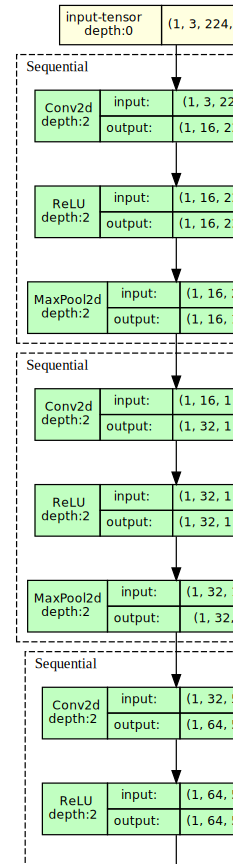

In [ ]:
cnn_model = CustomCNN()
model_graph = draw_graph(CustomCNN(), input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

### **_5.2. Arquitectura CNN_2**

In [ ]:
class custom_CNN2(pl.LightningModule):
    def __init__(self, num_classes=15, lr=1e-3, dropout_rate=0.5):
        super().__init__()

        self.num_classes = num_classes
        self.lr = lr
        self.dropout_rate = dropout_rate
        self.results = {"val_loss": [], "val_acc": [], "train_loss": [], "train_acc": []}

        # Capa 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,  # dimension de la imagen RGB = 3, escala de grises = 1
                out_channels=32,  # numero de filtros
                kernel_size=3,  # tamaño del filtro
                stride=1,  # valor de desplazamiento
                padding=1  # valor de relleno a los extremos
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Capa 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Capa 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Capa 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Capa 5
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Capa 6
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.adapt = nn.AdaptiveMaxPool2d((8, 8))
        self.fc = nn.Linear(1024 * 8 * 8, self.num_classes)

        self.dropout = nn.Dropout(p=self.dropout_rate)
        # Loss function
        self.loss = nn.CrossEntropyLoss()

        # Metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=self.num_classes)

        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.adapt(x)
        x = x.view(x.size(0), -1)  # se vuelve un vector 1d
        output = self.fc(x)

        return output

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        self.train_acc(preds, targets)

        loss = self.loss(outputs, targets)
        self.train_losses.append(loss.item())
        return loss

    def on_training_epoch_end(self):
        acc = self.train_acc.compute()
        self.log('avg_train_acc', acc)
        print(f"avg_train_acc: {acc}, ", end=" ")

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        preds = torch.argmax(outputs, dim=1)
        self.valid_acc(preds, targets)
        loss = self.loss(outputs, targets)
        self.val_losses.append(loss.item())

        # Registrar la métrica 'val_loss'
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        avg_val_acc = self.valid_acc.compute()
        self.log('avg_val_acc', avg_val_acc)
        print(f"avg_val_acc: {avg_val_acc}")

    def test_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        preds = torch.argmax(outputs, dim=1)
        self.test_acc(preds, targets)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        return loss

    def on_test_epoch_end(self):
        self.log('avg_test_acc', self.test_acc.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def get_loss_values(self):
    # Devolver las pérdidas recopiladas de entrenamiento y validación
        return self.train_losses, self.val_losses

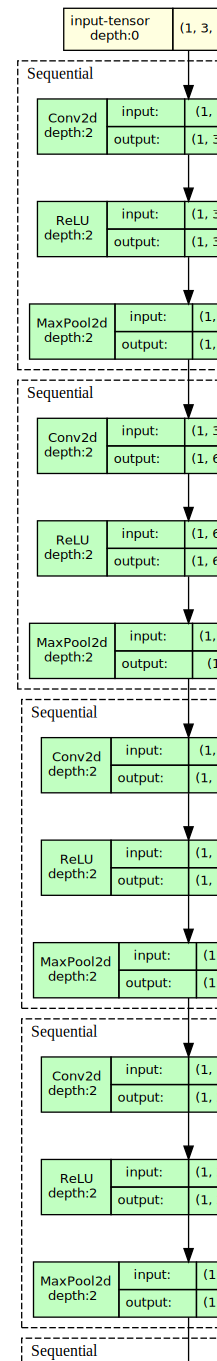

In [ ]:
model_graph = draw_graph(custom_CNN2(), input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

### **_5.3. Arquitectura CNN_3**

In [ ]:
class Custom_CNN3(pl.LightningModule):
    def __init__(self, num_classes=15, lr=1e-3, dropout_rate=0.5):
        super().__init__()

        self.num_classes = num_classes
        self.lr = lr
        self.dropout_rate = dropout_rate
        self.results = {"val_loss": [], "val_acc": [], "train_loss": [], "train_acc": []}

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.adapt = nn.AdaptiveMaxPool2d((8, 8))
        self.fc = nn.Linear(128 * 8 * 8, self.num_classes)

        self.dropout = nn.Dropout(p=self.dropout_rate)

        # Loss function
        self.loss = nn.CrossEntropyLoss()

        # Metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=self.num_classes)

        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adapt(x)
        x = x.view(x.size(0), -1)  # se vuelve un vector 1d
        x = self.dropout(x)
        output = self.fc(x)

        return output

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        self.train_acc(preds, targets)

        loss = self.loss(outputs, targets)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        preds = torch.argmax(outputs, dim=1)
        self.valid_acc(preds, targets)
        loss = self.loss(outputs, targets)
        self.val_losses.append(loss.item())

        # Registrar la métrica 'val_loss'
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.loss(outputs, targets)

        preds = torch.argmax(outputs, dim=1)
        self.test_acc(preds, targets)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def get_loss_values(self):
    # Devolver las pérdidas recopiladas de entrenamiento y validación
        return self.train_losses, self.val_losses

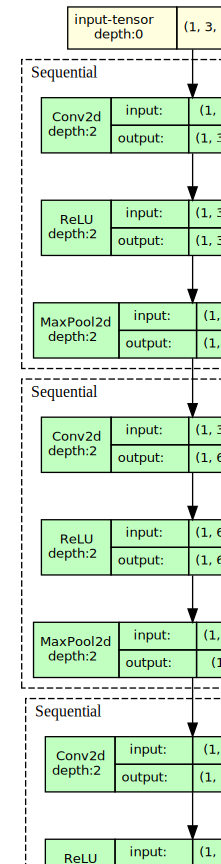

In [ ]:
model_graph = draw_graph(Custom_CNN3(), input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

## **6.-Configurando Hiperparámetros**

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
num_classes = 10
num_epochs = 20 # numero de épocas
batch_size = 10 # tamaño del batch
img_size = 224
lr =1e-3
data_dir = "/content/dataMariposas"

## **7.-Entrenamiento**

In [ ]:
# Función para graficar los valores de la función de pérdida
def plot_loss(losses, namelabel='Training Loss', color='red'):
    plt.plot(losses, label=namelabel, c=color)
    #lt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Función para el proceso de entrenamiento
seed_everything(42, workers=True)
def train_process(modelo, num_epochs, img_size, batch_size, data_dir):
    callback_model_checkpoint = ModelCheckpoint(
        filename='{epoch}-{val_loss:.3f}',
        monitor='val_loss',
        mode='min',
        dirpath="/content/results/"
    )

    dm = DataModule(data_dir=data_dir, img_size=img_size, batch_size=batch_size)
    trainer = Trainer(
        fast_dev_run=False,
        accelerator='gpu',
        log_every_n_steps=5,
        max_epochs=num_epochs,
        callbacks=[callback_model_checkpoint]
    )

    # Entrenar el modelo
    trainer.fit(modelo, dm)
      # Test
    trainer.test(modelo, dm)

    return modelo, callback_model_checkpoint.best_model_path


INFO:lightning_fabric.utilities.seed:Seed set to 42


### **_7.1. Entrenando el Modelo 1**

In [ ]:
model_cnn = CustomCNN(num_classes, lr)
model_cnn, best_model_path = train_process(model_cnn, num_epochs, img_size, batch_size, data_dir)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | conv1     | Sequential         | 448   
1 | conv2     | Sequential         | 4.6 K 
2 | conv3     | Sequential         | 18.5 K
3 | adapt     | AdaptiveMaxPool2d  | 0     
4 | fc        | Linear             | 41.0 K
5 | loss      | CrossEntropyLoss   | 0     
6 | train_acc | MulticlassAccuracy | 0     
7 | valid_acc | MulticlassAccuracy | 0     
8 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
64.6 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.05000000074505806


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.22857142984867096


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.375


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.4882352948188782


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.5545454621315002


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6000000238418579


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.609375


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6243243217468262


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6452381014823914


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6680850982666016


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.675000011920929


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6842105388641357


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6919354796409607


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7044776082038879


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7138888835906982


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7207792401313782


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7268292903900146


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7367815971374512


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7434782385826111


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7474226951599121


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


avg_val_acc: 0.7549019455909729


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       avg_test_acc        │    0.8916666507720947     │
│         test_acc          │    0.8916666507720947     │
│         test_loss         │    0.5932525992393494     │
└───────────────────────────┴───────────────────────────┘

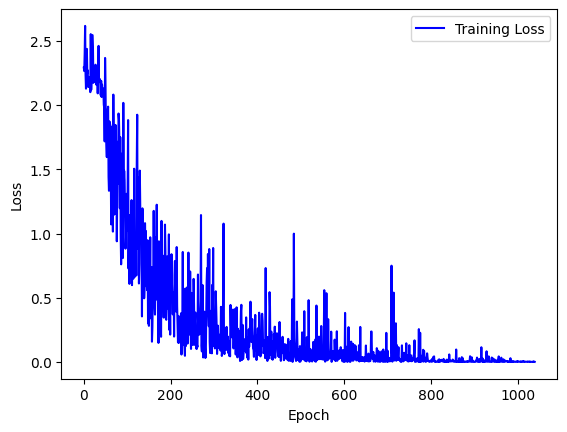

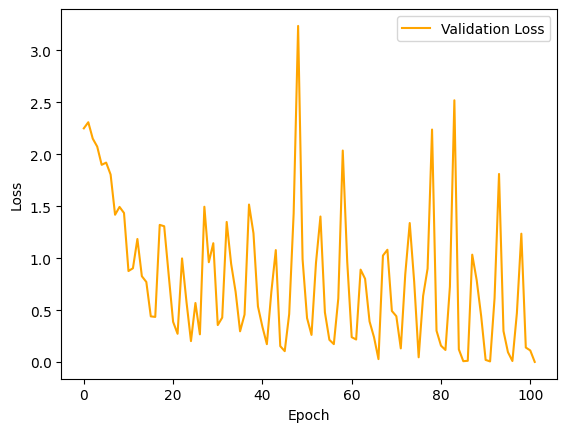

In [ ]:
# Obtener los valores de la función de pérdida después de todas las épocas
train_losses, val_losses = model_cnn.get_loss_values()
# Graficar los valores de la función de pérdida
plot_loss(train_losses,'Training Loss', 'blue')
plot_loss(val_losses,'Validation Loss', 'orange')

### **_7.2. Entrenando el Modelo 2**

In [ ]:
model_cnn2 = custom_CNN2(num_classes, lr)
model_cnn2, best_model_path2 = train_process(model_cnn2, num_epochs, img_size, batch_size, data_dir)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/results exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type               | Params
--------------------------------------------------
0  | conv1     | Sequential         | 896   
1  | conv2     | Sequential         | 18.5 K
2  | conv3     | Sequential         | 73.9 K
3  | conv4     | Sequential         | 295 K 
4  | conv5     | Sequential         | 1.2 M 
5  | conv6     | Sequential         | 4.7 M 
6  | adapt     | Adapti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.04285714402794838


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.17499999701976776


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.2823529541492462


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.3545454442501068


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.4148148000240326


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.46875


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.49459460377693176


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.550000011920929


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.5829787254333496


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6173076629638672


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6421052813529968


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6693548560142517


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.6895522475242615


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7041666507720947


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7129870057106018


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7256097793579102


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7390804886817932


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.75


Validation: |          | 0/? [00:00<?, ?it/s]

avg_val_acc: 0.7597938179969788


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


avg_val_acc: 0.7676470875740051


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       avg_test_acc        │    0.7749999761581421     │
│         test_acc          │    0.7749999761581421     │
│         test_loss         │    0.8782557249069214     │
└───────────────────────────┴───────────────────────────┘

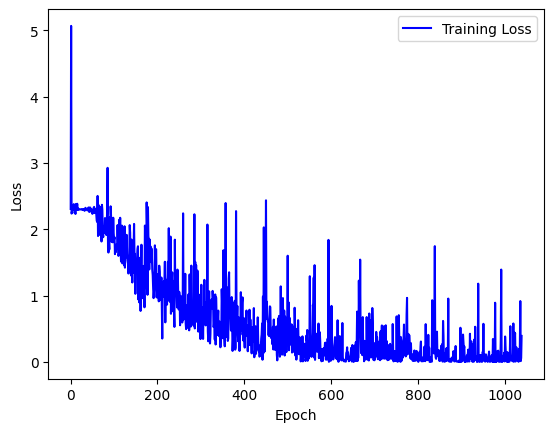

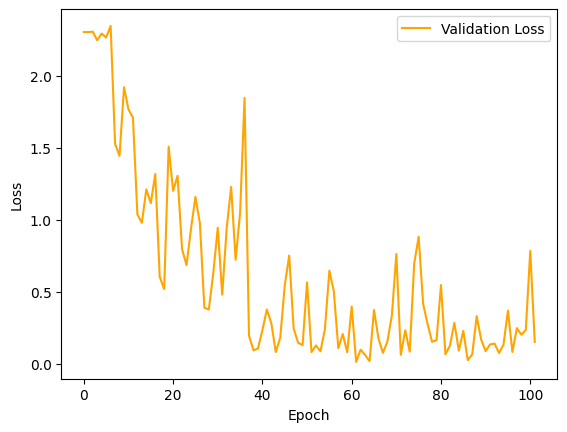

In [ ]:
train_losses, val_losses = model_cnn2.get_loss_values()
plot_loss(train_losses,'Training Loss', 'blue')
plot_loss(val_losses,'Validation Loss', 'orange')

### **_7.3. Entrenando el Modelo 3**

In [ ]:
model_cnn3 = Custom_CNN3(num_classes, lr)
model_cnn3, best_model_path3 = train_process(model_cnn3, num_epochs, img_size, batch_size, data_dir)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | conv1     | Sequential         | 896   
1 | conv2     | Sequential         | 18.5 K
2 | conv3     | Sequential         | 73.9 K
3 | adapt     | AdaptiveMaxPool2d  | 0     
4 | fc        | Linear             | 81.9 K
5 | dropout   | Dropout            | 0     
6 | loss      | CrossEntropyLoss   | 0     
7 | train_acc | MulticlassAccuracy | 0     
8 | valid_acc | MulticlassAccuracy | 0     
9 | test_acc  | MulticlassAccuracy | 0     
-----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8583333492279053     │
│         test_loss         │    0.6297222375869751     │
└───────────────────────────┴───────────────────────────┘

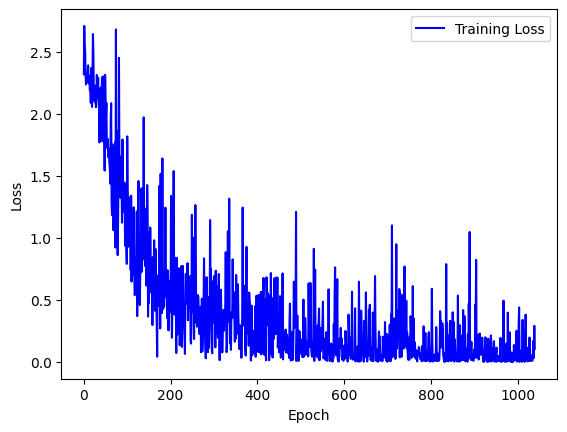

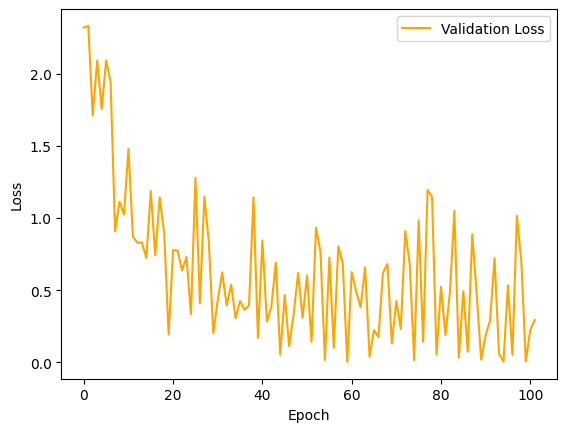

In [ ]:
train_losses, val_losses = model_cnn3.get_loss_values()
plot_loss(train_losses,'Training Loss', 'blue')
plot_loss(val_losses,'Validation Loss', 'orange')

# **8.-Pruebas del Modelo**

### **8.1. Pruebas Modelo 1**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval()
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)

    for i, (x, y) in enumerate(loader):
        #print(f"Cargando batch {i+1}")
        x, y = x.to(device),y.to(device)
        preds = model(x)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat(
            (all_labels, y)
            ,dim=0
        )
    return all_preds, all_labels

In [ ]:
model_sp = CustomCNN.load_from_checkpoint(best_model_path,num_classes=num_classes, lr=lr)

dm = DataModule(data_dir = data_dir, img_size = img_size, batch_size=1)
dm.setup()
loader = dm.test_dataloader()
all_preds, all_labels = get_all_preds(model_sp.to(device), loader)
y_true = all_labels.cpu()
y_pred =all_preds.argmax(dim=1).cpu()
labels = list(dm.categories)
cm = confusion_matrix(y_true, y_pred)
tot = np.sum(cm, axis=1)
cm_porc = np.divide(cm, np.reshape(tot, (-1,1)))


              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80        11
         1.0       0.91      0.83      0.87        12
         2.0       1.00      0.60      0.75         5
         3.0       0.83      0.88      0.86        17
         4.0       1.00      0.79      0.88        14
         5.0       1.00      0.85      0.92        13
         6.0       0.75      1.00      0.86        15
         7.0       1.00      0.92      0.96        12
         8.0       1.00      0.87      0.93        15
         9.0       0.77      0.91      0.83        11

    accuracy                           0.87       125
   macro avg       0.90      0.85      0.86       125
weighted avg       0.89      0.87      0.87       125



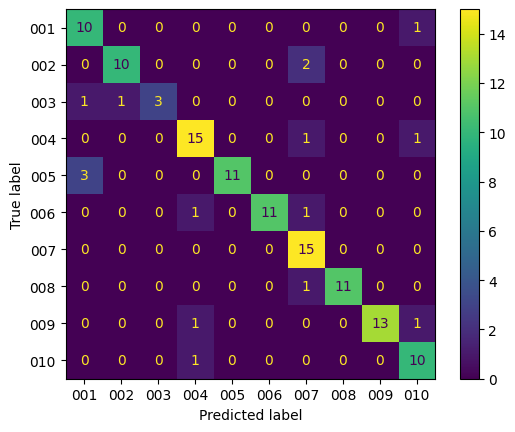

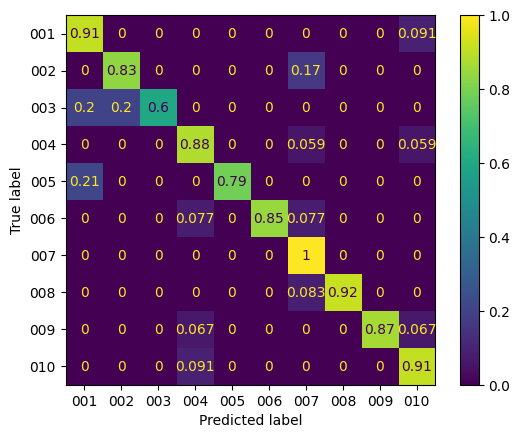

In [ ]:
report = classification_report(y_true, y_pred, output_dict=True)
print(classification_report(y_true, y_pred, zero_division=0))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_porc,display_labels=labels)
disp.plot()
plt.show()

### **8.2. Pruebas Modelo 2**

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87        11
         1.0       0.75      0.75      0.75        12
         2.0       0.75      0.60      0.67         5
         3.0       0.67      0.82      0.74        17
         4.0       0.73      0.79      0.76        14
         5.0       1.00      0.85      0.92        13
         6.0       1.00      0.67      0.80        15
         7.0       0.92      1.00      0.96        12
         8.0       1.00      0.87      0.93        15
         9.0       0.64      0.82      0.72        11

    accuracy                           0.82       125
   macro avg       0.83      0.81      0.81       125
weighted avg       0.84      0.82      0.82       125



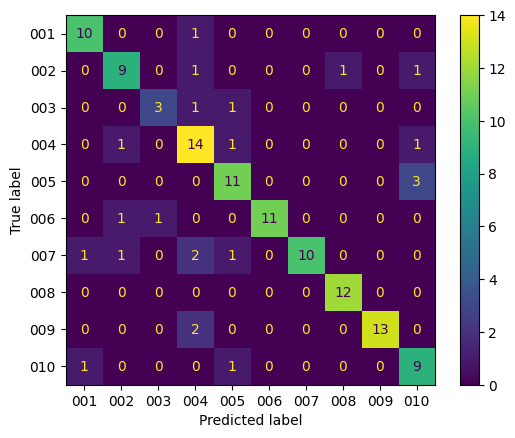

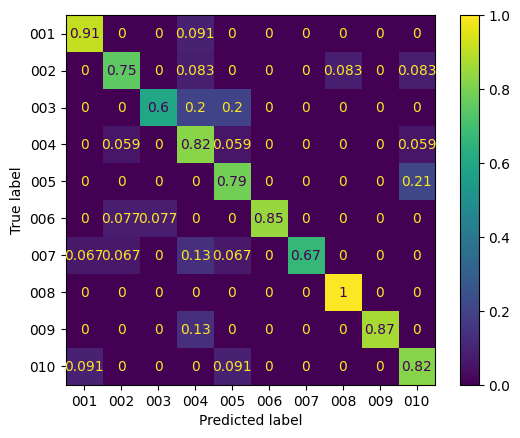

In [ ]:
model_sp2 = custom_CNN2.load_from_checkpoint(best_model_path2,num_classes=num_classes, lr=lr)

dm = DataModule(data_dir = data_dir, img_size = img_size, batch_size=1)
dm.setup()
loader = dm.test_dataloader()
all_preds, all_labels = get_all_preds(model_sp2.to(device), loader)
y_true = all_labels.cpu()
y_pred =all_preds.argmax(dim=1).cpu()
labels = list(dm.categories)
cm = confusion_matrix(y_true, y_pred)
tot = np.sum(cm, axis=1)
cm_porc = np.divide(cm, np.reshape(tot, (-1,1)))

report = classification_report(y_true, y_pred, output_dict=True)
print(classification_report(y_true, y_pred, zero_division=0))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_porc,display_labels=labels)
disp.plot()
plt.show()

### **8.3. Pruebas Modelo 3**

              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80        11
         1.0       0.91      0.83      0.87        12
         2.0       1.00      0.60      0.75         5
         3.0       0.83      0.88      0.86        17
         4.0       1.00      0.79      0.88        14
         5.0       1.00      0.85      0.92        13
         6.0       0.75      1.00      0.86        15
         7.0       1.00      0.92      0.96        12
         8.0       1.00      0.87      0.93        15
         9.0       0.77      0.91      0.83        11

    accuracy                           0.87       125
   macro avg       0.90      0.85      0.86       125
weighted avg       0.89      0.87      0.87       125



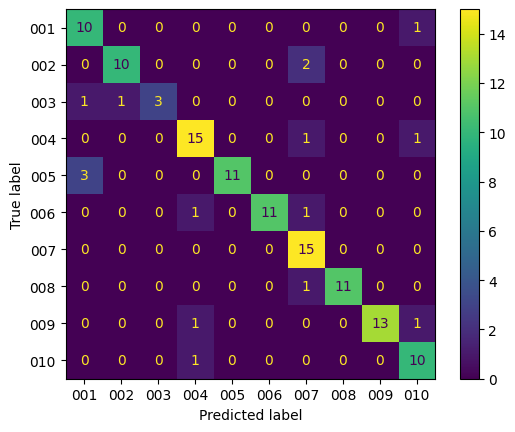

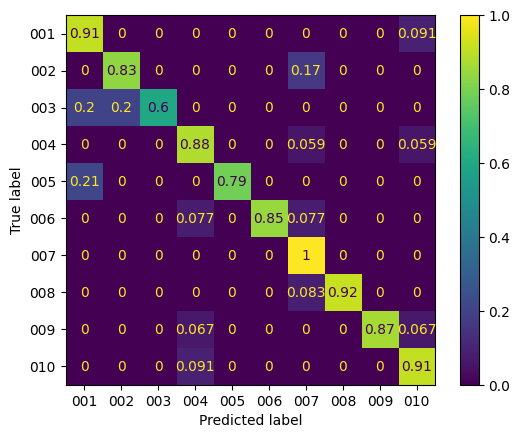

In [ ]:
model_sp3 = Custom_CNN3.load_from_checkpoint(best_model_path3,num_classes=num_classes, lr=lr)

dm = DataModule(data_dir = data_dir, img_size = img_size, batch_size=1)
dm.setup()
loader = dm.test_dataloader()
all_preds, all_labels = get_all_preds(model_sp3.to(device), loader)
y_true = all_labels.cpu()
y_pred =all_preds.argmax(dim=1).cpu()
labels = list(dm.categories)
cm = confusion_matrix(y_true, y_pred)
tot = np.sum(cm, axis=1)
cm_porc = np.divide(cm, np.reshape(tot, (-1,1)))

report = classification_report(y_true, y_pred, output_dict=True)
print(classification_report(y_true, y_pred, zero_division=0))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_porc,display_labels=labels)
disp.plot()
plt.show()